# Neural Networks

In this Notebook I will use the neural network to work on the digits recognizer problem. I will use the same data I used for the multi-class logistic regression.

Let's import the needed libraries

In [31]:
import scipy.io as sio
import numpy
from matplotlib import pyplot

Let's load the data separate to inputs and outputs and display it

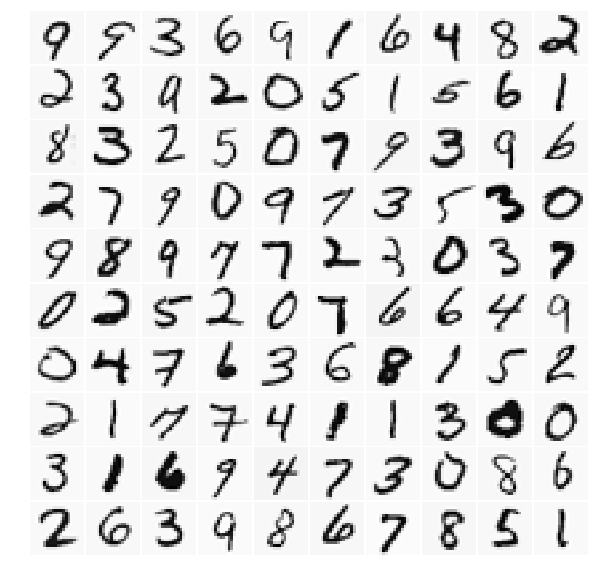

In [32]:
data = sio.loadmat('ex3data1.mat')


def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(numpy.round(numpy.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(numpy.floor(numpy.sqrt(m)))
    display_cols = int(numpy.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

    pyplot.show()


X, Y_ = data['X'], data['y'].ravel()

Y_[Y_==10]=0

m=Y_.size

# Randomly select 100 data points to display
rand_indices = numpy.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

## Logistic regression the building block

Logistic regression is the building block of neural networks, a neural network is basically a bunch of logistic regressions connected together. Let's review this:

<img src="image.png">

Image credit: https://github.com/PetarV-/TikZ/tree/master/Multilayer%20perceptron

As we can see in the picture, the logistic regression is the building block of the neural network.

## The math of logistic regression

We first compute the weighted sum:

$$z = WX + b$$

X is vector column of the form $(x_1,x_2,x_3,...,x_n)^T$
b is the bias

the output of the logistic regression is:
$$\sigma(WX + b)$$

The function $\sigma$ is what we call the sigmoid it takes the following form:
$$\sigma = \frac{1}{1+e^{-x}}$$

As I said above a neural network is bunch of logistic regressions connected together. we use the sigmoid function in the last neuron but for the others neuron we use another activation function which is $tanh(z)$

Let's define the 2 activation functions

In [33]:
def sigmoid(z):
    return 1/(1+numpy.exp(-z))

In [34]:
def tanh(z):
    return numpy.tanh(z)

I will also define the derivate of $tanh(z)$ which we will use in the gardient calculations

In [35]:
def derivative_tanh(z):
    t = numpy.tanh(z)
    return 1 - numpy.square(t)

And then let's encode the Y vector like we did for the multi-class logistic regression

In [36]:
def EncodeY(Y,m,K):
    Y_encoded = numpy.zeros((m,K))
    for j in range(K):
        for i in range(m):
            if Y[i] == j:
                Y_encoded[i,j] = 1
    return Y_encoded.reshape(K,m)

## Definition of the needed building blocks of the neural network

First, I will define a function that returns the dimensions of the network, the size of the input layer, the size of the hidden layer and the size of the output layer.

In [37]:
def dimensions(X,Y,h_dim):
    n_x = X.shape[0]
    n_h = h_dim
    n_y = Y.shape[0]
    return (n_x,n_h,n_y)

Let's initialize the parameters W and b

In [38]:
def parameters_initialization(dimensions):
    (n_x,n_h,n_y) = dimensions
    b1 = numpy.zeros((n_h,1))
    b2 = numpy.zeros((n_y,1))
    W1 = numpy.random.randn(n_h,n_x)*0.01
    W2 = numpy.random.randn(n_y,n_h)*0.01

    parameters={
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2
    }
    return parameters

Let's define the the forward_propagation function

In [39]:
def forward_propagation(X,parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']

    Z1 = numpy.dot(W1,X)+b1
    A1 = tanh(Z1)
    Z2 = numpy.dot(W2,A1)+b2
    A2 = sigmoid(Z2)

    cache = {
        'A1':A1,
        'A2':A2,
        'Z1':Z1,
        'Z2':Z2
    }

    return A2, cache

The cost function that will need to assess the performance of the neural network

In [40]:
def compute_cost(m,Y,A2):
    cost = (-1/m)*numpy.sum(Y*numpy.log(A2)+(1-Y)*numpy.log(1-A2))
    return cost

And then we have to define the backward_propagation function

In [41]:
def backward_propagation(X,Y,cache,parameters):
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    Z2 = cache['Z2']

    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']

    dZ2 = A2 - Y
    dW2 = (1/m)*numpy.dot(dZ2,A1.transpose())
    db2 = (1/m)*numpy.sum(dZ2,axis=1,keepdims=True)

    dZ1 = numpy.dot(W2.transpose(),dZ2)*derivative_tanh(Z1)
    dW1 = (1/m)*numpy.dot(dZ1,X.transpose())
    db1 = (1/m)*numpy.sum(dZ1,axis=1,keepdims=True)

    grads = {
        'dW1':dW1,
        'dW2':dW2,
        'db1':db1,
        'db2':db2
    }

    return grads

And finally a function to update the parameters W and b

In [42]:
def update_parameters(parameters,grads,learning_rate):

    parameters['W1'] = parameters['W1'] - learning_rate*grads['dW1']
    parameters['W2'] = parameters['W2'] - learning_rate*grads['dW2']
    parameters['b1'] = parameters['b1'] - learning_rate*grads['db1']
    parameters['b2'] = parameters['b2'] - learning_rate*grads['db2']

    return parameters

## Putting all together

Now we have all the need function to build the code and assess the performance

Let's define the hyperparameters

In [43]:
iterations = 1000 # to try
learning_rate = 0.01
Lambda = 1


K = 10 # The number of labels

# let's reshape X by transposing it and encode Y

# Let's start by encoding Y into a vector of 10 components
# where only the right index corresponding to the number is
# equal to 1.

X = X.transpose()
Y = EncodeY(Y_,m,K)

costs = []

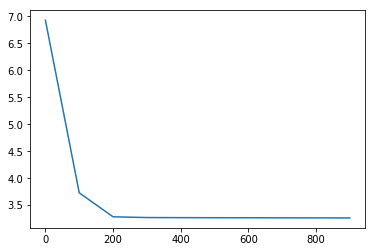

In [44]:
# Let's compute the dimensions

dimensions = dimensions(X,Y,25)

# Let's initialize the parameters 

parameters = parameters_initialization(dimensions)

for i in range(iterations):

    # Let's apply the forward propagation

    A2,cache = forward_propagation(X,parameters)

    # The cost function is 

    Cost_Function = compute_cost(m,Y,A2)

    grads = backward_propagation(X,Y,cache,parameters)

    parameters = update_parameters(parameters,grads,learning_rate)

    if i%100 == 0:
        costs.append(Cost_Function)

x = [100*item for item in range(len(costs))]        

pyplot.plot(x,costs)
pyplot.show()